Task 1

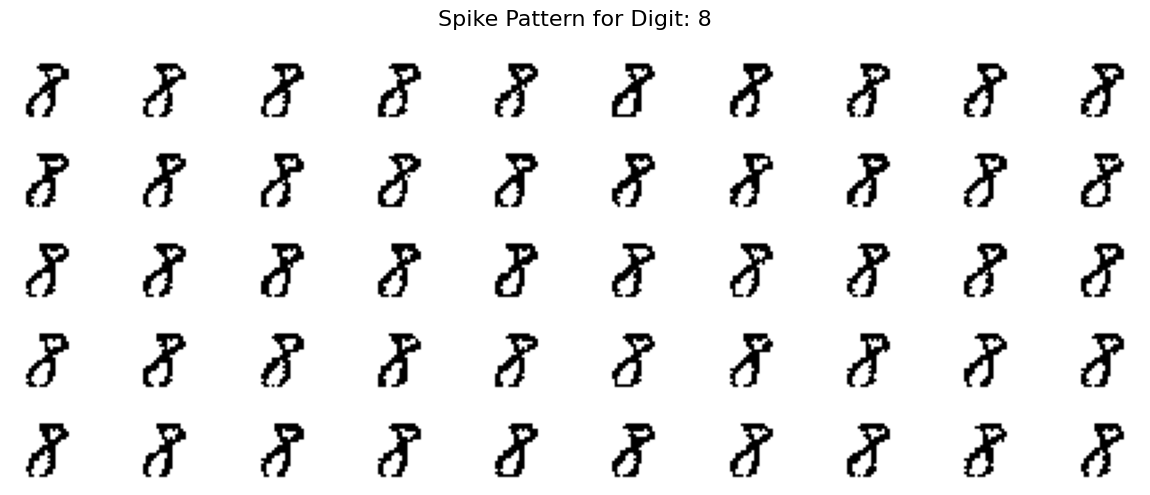

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),      #converting the image to tensor and also normalizing (intensity of pixel) between 0-1
])

mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)

def poisson_encoding(image, time_steps=100):  #converting an image to a spike train(i.e. the series of binary over time_step) using poisson_encoding 
    image = image.squeeze().numpy()
    spike_train = np.random.rand(time_steps, *image.shape) < image
    return spike_train.astype(np.float32)

#visually representing the spike train of an random image
data_iter = iter(mnist_loader)
image, label = next(data_iter)

spike_train = poisson_encoding(image[0], time_steps=50)

fig, axs = plt.subplots(5, 10, figsize=(12, 5))
fig.suptitle(f"Spike Pattern for Digit: {label.item()}", fontsize=16)

for t in range(50):
    axs[t // 10][t % 10].imshow(spike_train[t], cmap='Greys') # here "t//10" and "t%10" is row and column for any specific pixel
    axs[t // 10][t % 10].axis('off')

plt.tight_layout()
plt.show()

Task 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

def poisson_encoding(image, time_steps=20): #converting an image into spike train
    image = image.squeeze().numpy()
    spike_train = np.random.rand(time_steps, *image.shape) < image
    return spike_train.astype(np.float32)

class LIFNeuronLayer(nn.Module):
    def __init__(self, input_size, output_size, threshold=1.0, decay=0.9):
        super(LIFNeuronLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        self.threshold = threshold
        self.decay = decay

    def forward(self, input_spikes, mem):
        # Integrate and Leak
        current = self.fc(input_spikes)
        mem = self.decay * mem + current

        spikes = self.surrogate_spike(mem - self.threshold) # generates spikes if membrane potential touches threshold 

        mem = mem * (1 - spikes) # reset potential after spike

        return spikes, mem

    def surrogate_spike(self, x):
        return torch.sigmoid(5 * x) # sigmoid based surrogate (smooth step function)

class SNNModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(SNNModel, self).__init__()
        self.hidden = LIFNeuronLayer(input_size, hidden_size)
        self.output = LIFNeuronLayer(hidden_size, output_size)

    def forward(self, spike_input, time_steps):
        batch_size = spike_input.shape[1]

        # membrane potentials
        mem_h = torch.zeros(batch_size, self.hidden.fc.out_features).to(spike_input.device)
        mem_o = torch.zeros(batch_size, self.output.fc.out_features).to(spike_input.device)

        spike_sum = torch.zeros_like(mem_o) # total spike count in output layer

        for t in range(time_steps):
            x_t = spike_input[t]
            spikes_h, mem_h = self.hidden(x_t, mem_h)
            spikes_o, mem_o = self.output(spikes_h, mem_o)
            spike_sum += spikes_o

        return spike_sum

# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data loading and preprocessing
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_small = Subset(mnist, range(2000))  # using 2000 samples for testing
loader = DataLoader(mnist_small, batch_size=8, shuffle=True)

model = SNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

time_steps = 30

#training loop
for epoch in range(10):
    correct = 0
    total = 0
    total_loss = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/10")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        batch_spikes = []
        for b in range(images.shape[0]):
            spike_train = poisson_encoding(images[b].cpu(), time_steps)
            batch_spikes.append(torch.tensor(spike_train))

        spike_input = torch.stack(batch_spikes).permute(1, 0, 2, 3)  # SNN model expect (time, batch_size, height, width)
        spike_input = spike_input.reshape(time_steps, images.shape[0], -1).float().to(device)

        outputs = model(spike_input, time_steps)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    print(f"Epoch {epoch+1} Accuracy: {correct/total:.4f}")

Epoch 1/10: 100%|██████████| 250/250 [00:11<00:00, 21.76it/s, acc=0.546, loss=0.0848]


Epoch 1 Accuracy: 0.5460


Epoch 2/10: 100%|██████████| 250/250 [00:10<00:00, 23.65it/s, acc=0.837, loss=0.526]  


Epoch 2 Accuracy: 0.8370


Epoch 3/10: 100%|██████████| 250/250 [00:11<00:00, 21.98it/s, acc=0.924, loss=0.408]   


Epoch 3 Accuracy: 0.9245


Epoch 4/10: 100%|██████████| 250/250 [00:13<00:00, 18.13it/s, acc=0.943, loss=0.0851]  


Epoch 4 Accuracy: 0.9425


Epoch 5/10: 100%|██████████| 250/250 [00:14<00:00, 17.42it/s, acc=0.967, loss=0.648]   


Epoch 5 Accuracy: 0.9665


Epoch 6/10: 100%|██████████| 250/250 [00:14<00:00, 17.00it/s, acc=0.974, loss=0.0472]  


Epoch 6 Accuracy: 0.9740


Epoch 7/10: 100%|██████████| 250/250 [00:16<00:00, 15.33it/s, acc=0.987, loss=0.412]   


Epoch 7 Accuracy: 0.9865


Epoch 8/10: 100%|██████████| 250/250 [00:18<00:00, 13.16it/s, acc=0.986, loss=0.0428]  


Epoch 8 Accuracy: 0.9855


Epoch 9/10: 100%|██████████| 250/250 [00:20<00:00, 12.50it/s, acc=0.991, loss=0.0102]  


Epoch 9 Accuracy: 0.9910


Epoch 10/10: 100%|██████████| 250/250 [00:18<00:00, 13.60it/s, acc=0.995, loss=0.00263] 

Epoch 10 Accuracy: 0.9945


Task 3

In [ ]:
#loading MNIST test set
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=16, shuffle=False)

def evaluate(model, test_loader, time_steps=30):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            batch_spikes = []

            for b in range(images.shape[0]):
                encoded = poisson_encoding(images[b].cpu(), time_steps)
                batch_spikes.append(torch.tensor(encoded))

            spike_input = torch.stack(batch_spikes).permute(1, 0, 2, 3)
            spike_input = spike_input.reshape(time_steps, images.shape[0], -1).float().to(device)

            outputs = model(spike_input, time_steps)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"\nTest Accuracy: {test_acc:.4f}")
    return test_acc

# Running evaluation
test_accuracy = evaluate(model, test_loader, time_steps=30)


Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 625/625 [00:17<00:00, 36.35it/s]


Test Accuracy: 0.9191
